In [16]:
#initialize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import scale

2. Batch data analysis

In this problem, we will look into batch data; dynamic time-series of a finite duration 2. Batch
manufacturing processes are very common in chemical, pharma, bioengineering and semi-
conductor industries such as baker’s yeast production, beer brewing and vaccines production.

In theory, a reactor is designed with temperature, pressure, level, pH control and multiple
sensors that measure these variables among others. A perfect batch (again in theory) is one
that is tightly controlled to the specifications and as a result the productivity and quality of
the final product is optimized.

In real life, a typical batch is run from a few hours up to a week or two and a lot of things
can go wrong during this period. There is always variability either because the process is
very sensitive to minor fluctuations in some variables or the control of some variables failed
for a period of time.

In a company that implements Data Analytics or Multivariate Statistical Process Control
(MSPC) monitoring is typically implemented with the following steps:
1. Identify a number of reference, perfect historical batches (15-20), both in terms of high
productivity/quality and minimum anomalies or fluctuations around the setpoints.
2. Create a PCA model of the perfect batches identified. This is your model.
3. Every time your site is running a new batch, fit your data online or as soon as your
data infrastructure allows you to do so. Fitting will tell you whether your batch is
similar to the perfect batches or it is deviating from the reference behaviour.

Next, you will follow these steps to build a Batch Statistical Process Control and implement
it to monitor a new batch (we will assume that you got the data at the end of the batch
and fit them to the model). The dataset is from a baker’s yeast production facility in Solna,
Sweden capturing the last step of the fermentation.

2.1.1 - Import the data from ’bakers yeast reference batches.xlsx’. Identify how many batches
are in the data. What is the duration of each batch and how many data points are
there per batch? How many variables are measured (including time)?

In [17]:
#Reading in Excel file
yeast = pd.read_excel('bakers_yeast_reference_batches.xlsx')
yeast = yeast.drop(['Unnamed: 0'], axis = 1)
yeast.head()

,Primary ID,BatchID,Time,Ethanol,Temperature,Molasses flow,NH3 flow,Air flow,Level,pH
0,250,bb,0.000000,0.05059,31.9580,212.328,6.16453,1382.19,43.4194,5.85607
1,251,bb,0.166667,0.04930,31.5303,835.476,29.78270,2084.42,43.4853,5.34603
2,252,bb,0.333333,0.04973,30.8220,910.155,32.50710,2266.47,43.5628,5.18718
3,253,bb,0.500000,0.04915,30.1617,985.011,36.37100,2446.84,43.6002,5.18043
4,254,bb,0.666667,0.04744,29.8891,1052.450,39.26990,2636.96,43.6572,5.18145


Duration of each batch is represented by the time column, there are 8 data points/variables measured per batch.

2.1.2 - Plot the variables time-profiles in a 2x4 subplot. Inspect the graphs (don’t just plot
them). Look for potential outliers. Which variables have the largest variability? Which
variables are tightly controlled?

<Figure size 720x360 with 0 Axes>

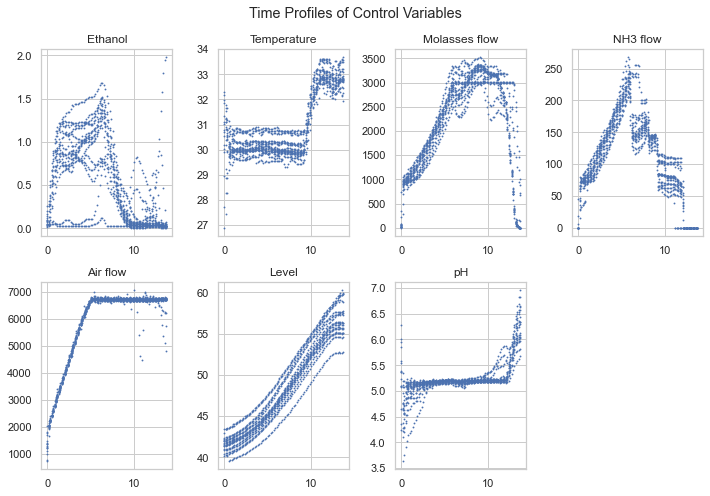

In [18]:
#ploting the 7 time profiles of the control variables
fig = plt.figure()
fig.set_size_inches(10, 5)
f, ax = plt.subplots(2,4)
f.suptitle('Time Profiles of Control Variables')
ax[0,0].scatter(yeast['Time'], yeast['Ethanol'], s = 0.7)
ax[0,0].set_title('Ethanol')
ax[0,1].scatter(yeast['Time'], yeast['Temperature'], s = 0.7)
ax[0,1].set_title('Temperature')
ax[0,2].scatter(yeast['Time'], yeast['Molasses flow'], s = 0.7)
ax[0,2].set_title('Molasses flow')
ax[0,3].scatter(yeast['Time'], yeast['NH3 flow'], s = 0.7)
ax[0,3].set_title('NH3 flow')
ax[1,0].scatter(yeast['Time'], yeast['Air flow'], s = 0.7)
ax[1,0].set_title('Air flow')
ax[1,1].scatter(yeast['Time'], yeast['Level'], s = 0.7)
ax[1,1].set_title('Level')
ax[1,2].scatter(yeast['Time'], yeast['pH'], s = 0.7)
ax[1,2].set_title('pH')
f.delaxes(ax[1,3])
f.tight_layout(pad=1)
sns.set_style('whitegrid')
plt.show()

From looking at the 7 plots above, we can see that the ethanol and molasses flow plots have many outliers and seems like that the data does not all follow a specific trend. We can see that the data increases in molasses flow but all at different rates with a fall off near the end of the process. In the ethanol graph, the data splits off into a range that covers from 0.6 to 1.2 up until 7-8 min mark when all ethanol levels fall. Additionally, the variance in the dataset grows as the process reaches completion, there are many outliers that spike up in ethanol concentration, when compared to the mean distribution. For the molasses flow, the data mostly follows some trend that increases to 5-10 mins before falling back down to 0 again. But this trend has a lot of uncertainty as there are regions in the trend "line" where points flutuate around the mean distribution of the data. 

Similarly, we can see that the temperature plot has a large variance at the process start up, but it follows a trend of holding a constant temperature before increasing at the end of the process. Although there are variances to the temperature, fluctuating from 29.5 to 31 degrees during the process time.

The variables that are tightly controlled are air flow, level, and pH. There process variables all have data that follow a trend tightly with very few outliers. You can see a distinct line or lines that indicate the desired process control. In the pH plot, there are regions in the beginning and end of the process that have larger variabilities, but it mostly follows a trend at holding a pH of 5 during the process. The difference is that the level plot shows several run conditions that follow the same trend but different values, introducing variance in the data.

A unique case is the NH3 flow. There looks like discontinuities in the trend that the data follows, there are jumps in the perceived "trend line" but the data follows this trend with very few outliers. Similar to temperature and the level, there are wide operating ranges for this variable (variance).

2.1.3 - Select the features (including the Time column), pre-process the data and perform
PCA with 5 principal components. Extract the scores and loadings.

In [19]:
#pre-processing the data and performing PCA for 5 PC's
yeast_process = yeast.iloc[:, 2:]
ss = StandardScaler()
transform_yeast = ss.fit_transform(yeast_process)
pca = PCA(n_components=5, svd_solver='full')
pca_element = pca.fit_transform(transform_yeast)
scores_pd = pd.DataFrame(data = pca_element,columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],index = yeast_process.index)
loading_pd = pd.DataFrame(data = pca.components_.T,columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],index = yeast_process.columns)

2.1.4 - In order to plot the scores-loading plot, you need to pivot the scores BatchID with
index ’Time’ (use pandas pivot table).

In [20]:
#Performing pivot with transformed data
batchid = yeast['BatchID']
time = yeast['Time']
# adjusting the scores to fit in (-1,1), for plotting later
pot_x = pca_element[:,:2]
xt = pot_x[:,0]
yt = pot_x[:,1]
n = loading_pd.shape[0]
scalext = 1.0/(xt.max() - xt.min())
scaleyt = 1.0/(yt.max() - yt.min())
xt_scaled = xt * scalext
yt_scaled = yt * scaleyt
std_pca = pd.DataFrame({'PC1': xt_scaled, 'PC2': yt_scaled})
#appending label columns for pivot table
yeast_score = pd.concat([std_pca, batchid, time], axis = 1)
#pivot table here
batch = yeast_score.pivot_table(index = 'Time', columns = 'BatchID')

2.1.5 - Plot the scores-loadings plot with one line per batch (this is why the pivot in the
previous step was needed). The output should look similar to the plot below. You
may choose a different scaling, but the trend should be the same as this graph.

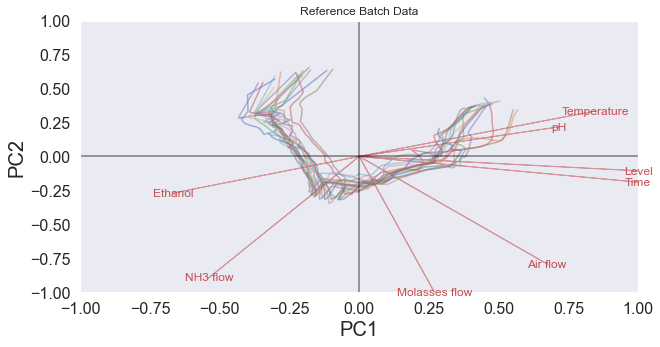

In [21]:
# adjusting the loadings to fit in (-1,1)
p = loading_pd.iloc[:,:2]
p_scaled = MaxAbsScaler().fit_transform(p)
fig = plt.figure()
fig.set_size_inches(10, 5)
#plotting the pivotted data
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(10,5)})

length = int(len(batch.columns))
for i in range(length//2):
    plt.plot(batch.iloc[:,i], batch.iloc[:,i+length//2], alpha = 0.5)

#plotting the vectors representing each variable
for i in range(n):
    plt.arrow(0, 0, p_scaled[i,0], p_scaled[i,1], color = 'r',alpha = 0.5)
    plt.text(p_scaled[i,0], p_scaled[i,1], loading_pd.index[i], color = 'r', ha = 'center', va = 'center', size=12)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.title('Reference Batch Data')
plt.xlabel("PC{}".format(1), fontsize=20)
plt.ylabel("PC{}".format(2), fontsize=20)
plt.axvline(x=0, c="black", alpha = 0.5)
plt.axhline(y=0, c="black", alpha = 0.5)
plt.tick_params(labelsize=16)
plt.grid()

2.1.6 - Explain this graph. In which quarter do the batches start and end? What happens at
the kink where the direction of the lines changes? Can you tell from this graph which
variables do not change in the first phase and which in the second phase?

Using the time arrow, we can observe that the batches start their operation in the second quadrant and ends in the first quadrant. The first kink in the data indicates the first increase in temperature and pH as the data heads toward the direction of those two arrow vectors. Additionally at this first kink, or the second phase, the ethanol level and NH3 flow begin to decrease as time of process continues. The variables that stay constant past the kink are molassses flow and air flow. In the first phase, the variables that are unchanging are ethanol, NH3 flow, temperature, pH. These observations can be made by comparing the projections of each data line to the arrow vector of each variable. Most of the data lines are mostly orthogonal to each respective vector in their phase, indicating little-to-no change in that variable.

2.1.7 - Plot the cumulative explained variance. How much variance do the first two principal
components capture?

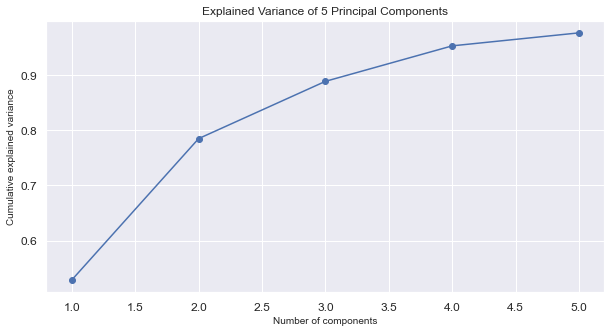

[0.52860131 0.78467377 0.88843351 0.95271965 0.97625353]


In [26]:
#plotting the cumulative explained variance for 5 PC's
cum_exp_var = np.cumsum(pca.explained_variance_ratio_)

sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(10,5)})

plt.plot(range(1,pca.n_components+1), np.cumsum(pca.explained_variance_ratio_),'-o')
plt.title("Explained Variance of 5 Principal Components")
plt.xlabel('Number of components', fontsize=10)
plt.ylabel('Cumulative explained variance', fontsize=10);
plt.tick_params(labelsize=12)
plt.show()
print(cum_exp_var)

The first 2 PC's capture 78.4% of the variance in the data

2.2.1 - Load the data from the file ’todays batches.xlsx’ and repeat the same procedure as in
the steps 3-4 of the previous section with the exception of the PCA modeling. Here,
instead of fit the data to the model and transform, you will only transform them with
the model object you created in the previous section.

In [23]:
#Reading in the excel for today's data
today = pd.read_excel('todays_batches.xlsx')
today = today.drop(['Unnamed: 0'], axis = 1)

#pre-processing the data and performing PCA for 5 PC's
today_process = today.iloc[:, 2:]
transform_today = ss.transform(today_process)
pca_today = pca.transform(transform_today)
t_scores_pd = pd.DataFrame(data = pca_today,columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],index = today_process.index)
t_loading_pd = pd.DataFrame(data = pca.components_.T,columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],index = today_process.columns)

In [24]:
#Performing pivot with transformed data
t_batchid = today['BatchID']
t_time = today['Time']
pot_x = pca_today[:,:2]
# adjusting the scores to fit in (-1,1), for plotting later
xt = pot_x[:,0]
yt = pot_x[:,1]
scalext = 1.0/(xt.max() - xt.min())
scaleyt = 1.0/(yt.max() - yt.min())
xt_scaled = xt * scalext
yt_scaled = yt * scaleyt
t_std_pca = pd.DataFrame({'PC1': xt_scaled, 'PC2': yt_scaled})
#appending label columns for pivot table
today_score = pd.concat([t_std_pca, batchid, t_time], axis = 1)
#pivot table here
t_batch = today_score.pivot_table(index = 'Time', columns = 'BatchID')

2.2.2 - Plot the same scores-loadings plot for the data in the batches you used to develop the
model with solid lines. Overlay the new incoming data from the two current batches
with dashed lines and two different colours to distinguish them. Also, add a legend for
the two batches so that the viewer can distinguish them.

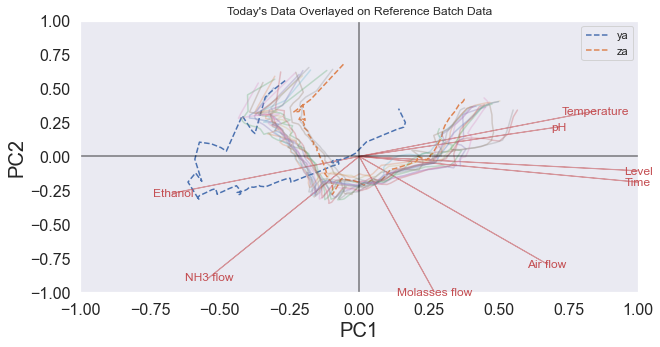

In [25]:
fig = plt.figure()
fig.set_size_inches(10, 5)

sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(10,5)})

#plotting the data from today
t_length = int(len(t_batch.columns))
for i in range(t_length//2):
    plt.plot(t_batch.iloc[:,i], t_batch.iloc[:,i+t_length//2], alpha = 1, ls = 'dashed')
    plt.legend(['ya', 'za'])

#plotting the reference data
for i in range(length//2):
    plt.plot(batch.iloc[:,i], batch.iloc[:,i+length//2], alpha = 0.3)

# adjusting the loadings to fit in (-1,1)
n = t_loading_pd.shape[0]
p = loading_pd.iloc[:,:2]
p_scaled = MaxAbsScaler().fit_transform(p)

#plotting the vectors of each variable
for i in range(n):
    plt.arrow(0, 0, p_scaled[i,0], p_scaled[i,1], color = 'r',alpha = 0.5)
    plt.text(p_scaled[i,0], p_scaled[i,1], loading_pd.index[i], color = 'r', ha = 'center', va = 'center', size=12)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.title("Today's Data Overlayed on Reference Batch Data")
plt.xlabel("PC{}".format(1), fontsize=20)
plt.ylabel("PC{}".format(2), fontsize=20)
plt.tick_params(labelsize=16)

plt.axvline(x=0, c="black", alpha = 0.5)
plt.axhline(y=0, c="black", alpha = 0.5)
plt.grid()

2.2.3 - Do the batches show behaviour similar to that of the reference ones or there are outliers
indicating potential problems?

Batch ya (blue line) shows a much different trend than the reference data such that the ethanol content drastically increases during the supposed phase 1 of the process. It then follows a similar trend in the phase 2, but with much lower airflow and molasses flow content. This drastic variable outlier change in the data may negatively affect product quality and process reproducibility.

Batch za (orange line) however, follows directly in the trend of the reference data, sitting in the middle of the data. This suggests that batch za is representative of the historic data and will produce expected results in the process and will be reliable.